Example notebook showing how to use the nested sampler with a lower number of live points and MCMC steps

In [1]:
import os
import sys
import argparse
import torch
import logging
from getdist import plots, MCSamples
import getdist
import numpy as np
from scipy.stats import multivariate_normal

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest import NestedSampler
from nnest.likelihoods import *

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Likelihood + prior
#like = Himmelblau(2)
#transform = lambda x: 5*x
#like = Rosenbrock(4)
#transform = lambda x: 5*x
#like = Gaussian(2, 0.9)
#transform = lambda x: 3*x
#like = Eggbox(2)
#transform = lambda x: 5*np.pi*x
like = GaussianShell(2)
transform = lambda x: 5*x
#like = GaussianMix(2)
#transform = lambda x: 5*x

In [6]:
sampler = NestedSampler(like.x_dim, like, transform=transform, num_live_points=100, hidden_dim=16, 
                        num_blocks=3, flow='spline')

Creating directory for new run logs/test/run43
[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_fe

In [7]:
sampler.run(strategy=['rejection_prior', 'rejection_flow', 'mcmc'], mcmc_steps=5*like.x_dim)

[nnest.sampler] [INFO] MCMC steps [10]
[nnest.sampler] [INFO] Initial scale [1.4142]
[nnest.sampler] [INFO] Volume switch [-1.0000]
[nnest.sampler] [INFO] Step [0] loglstar [-1.0548e+03] max logl [-2.3596e-01] logz [-1.0594e+03] vol [1.00000e+00] ncalls [101] mean calls [0.0000]
[nnest.sampler] [INFO] Step [20] loglstar [-5.1832e+02] max logl [-1.2674e-01] logz [-5.2310e+02] vol [8.18731e-01] ncalls [122] mean calls [1.0500]
[nnest.sampler] [INFO] Step [40] loglstar [-3.6241e+02] max logl [-1.2674e-01] logz [-3.6742e+02] vol [6.70320e-01] ncalls [146] mean calls [1.2000]
[nnest.sampler] [INFO] Step [60] loglstar [-2.8392e+02] max logl [-1.2674e-01] logz [-2.8896e+02] vol [5.48812e-01] ncalls [189] mean calls [2.1500]
[nnest.sampler] [INFO] Step [80] loglstar [-1.6723e+02] max logl [-1.2674e-01] logz [-1.7264e+02] vol [4.49329e-01] ncalls [229] mean calls [2.0000]
[nnest.sampler] [INFO] Step [100] loglstar [-1.1476e+02] max logl [-1.2674e-01] logz [-1.1979e+02] vol [3.67879e-01] ncalls 

In [8]:
print(sampler.logz)

-3.5340588647402096


In [9]:
mc = MCSamples(samples=sampler.samples, weights=sampler.weights, loglikes=-sampler.loglikes)

Removed no burn in


In [10]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.likeStats)

255.58195514915934
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
param1     -7.0843628E-02  1.3891140E+00 -2.0624780E+00  1.9390887E+00  two   -2.2231773E+00  2.1480638E+00  two   -2.1568495E+00  2.0938048E+00  two     p_{1}
param2      3.5671697E-02  1.4397762E+00 -2.0846136E+00  2.0977986E+00  two   -2.0411054E+00  2.0559058E+00  two   -2.1310663E+00  2.1211998E+00  two     p_{2}

Best fit sample -log(Like) = 0.000013
mean(-Ln(like)) = 0.512557
-Ln(mean like)  = 0.354646

parameter   bestfit        lower1         upper1         lower2         upper2
param1      1.0287925E+00 -2.0544088E+00  2.0573355E+00 -2.1568495E+00  2.0938048E+00   p_{1}
param2      1.7156939E+00 -2.0421554E+00  2.0798549E+00 -2.1715217E+00  2.1270088E+00   p_{2}



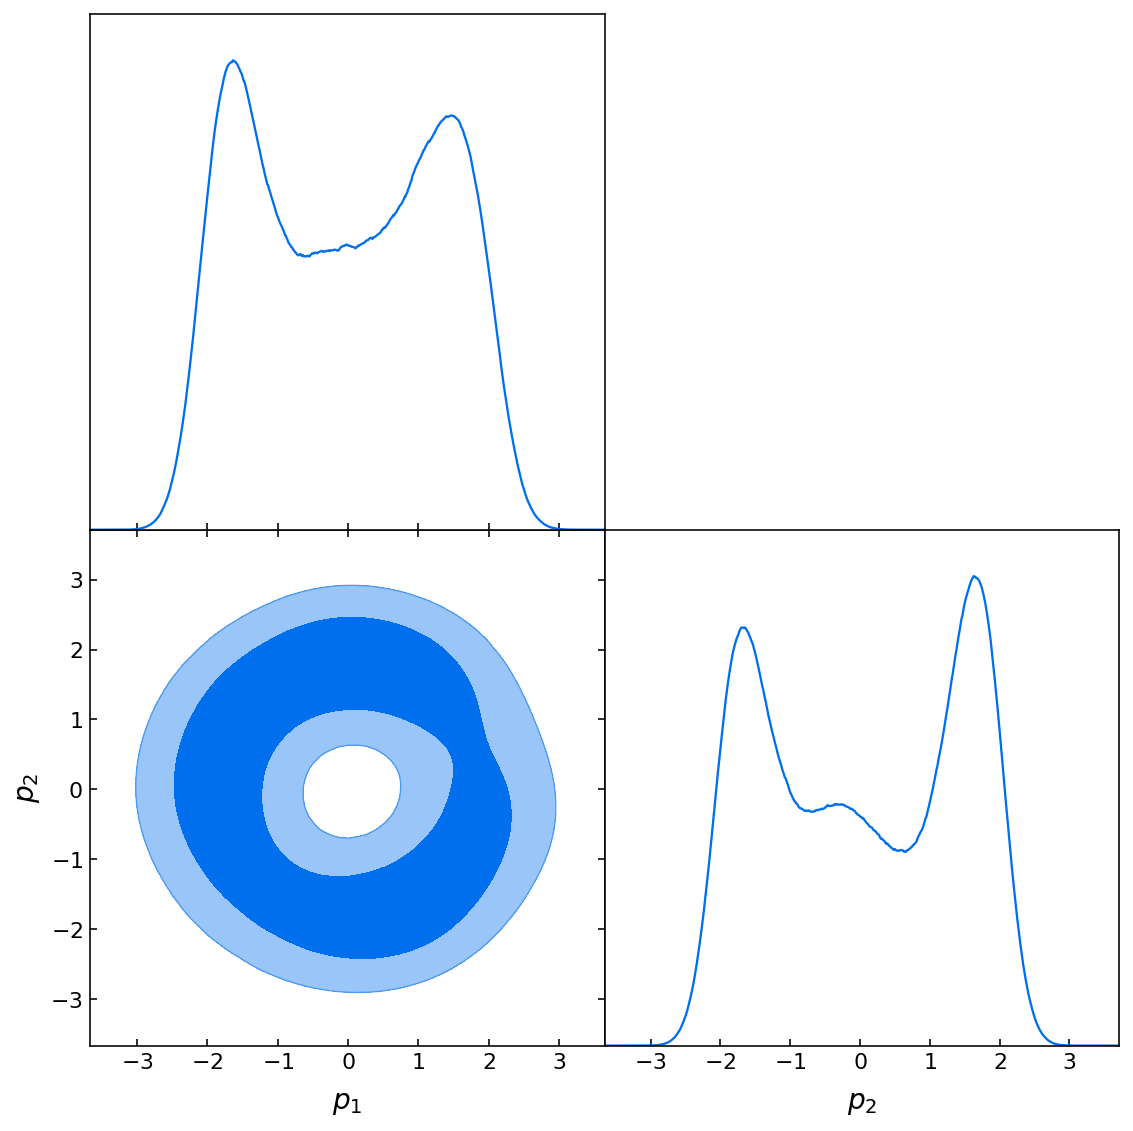

In [16]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)

In [14]:
v = 1
m = mc.getMargeStats()
for i in range(like.x_dim):
    upper = m.names[i].mean + 2*m.names[i].err
    lower = m.names[i].mean - 2*m.names[i].err
    r = upper - lower
    v *= r
print(v / 10**like.x_dim)

0.32000213473720124
